In [31]:
import json
import requests
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
from matplotlib import pyplot as plt
import uuid
import re
from typing import Callable

In [84]:
API_BASE_URL = "http://localhost:8000"

ROLE_MAP = {
    5: 'start',
    6: 'hand',
    7: 'finish',
    8: 'foot'
}

def df_sql(db_name, query,index_col='uuid'):
    """Extract table <table_name> from database <db_name>.db"""
    with sqlite3.connect(f"data/boardlib/{db_name}.db") as conn:
        df = pd.read_sql_query(query,conn,index_col=index_col)
    return df

def convert_dataframe_to_holds(df: pd.DataFrame, 
                                 default_pull_x: float = 0.0,
                                 default_pull_y: float = -1.0,
                                 default_useability: float = 0.5) -> list[dict]:
    """
    Convert pandas DataFrame to list of hold dictionaries.
    
    Args:
        df: DataFrame with 'hole_id', 'x_ft', 'y_ft' columns
        default_pull_x: Default pull direction x-component
        default_pull_y: Default pull direction y-component  
        default_useability: Default difficulty rating (0-1)
        default_is_foot: Whether hold is a foothold (0 or 1)
    
    Returns:
        List of hold dictionaries matching the API schema
    """
    holds = []
    
    for _, row in df.iterrows():
        hold = {
            "hold_index": int(row['hole_id']),
            "x": float(row['x_ft']),
            "y": float(row['y_ft']),
            "pull_x": default_pull_x,
            "pull_y": default_pull_y,
            "useability": default_useability,
            "is_foot": int(row['is_foot'])
        }
        holds.append(hold)
    
    return holds


def upload_holds(wall_id: str, holds: list[dict], api_base_url: str = API_BASE_URL) -> dict:
    """
    Upload holds to the API.
    
    Args:
        wall_id: The wall ID to upload holds to
        holds: List of hold dictionaries
        api_base_url: Base URL of the API
    
    Returns:
        Response JSON from the API
    """
    endpoint = f"{api_base_url}/api/v1/walls/{wall_id}/holds"
    
    # Prepare form data with JSON-encoded holds
    form_data = {
        "holds": json.dumps(holds)
    }
    
    print(f"Uploading {len(holds)} holds to wall {wall_id}...")
    print(f"Endpoint: {endpoint}")
    
    response = requests.put(endpoint, data=form_data)
    
    if response.status_code == 201:
        print(f"✓ Successfully uploaded {len(holds)} holds!")
        return response.json()
    else:
        print(f"✗ Upload failed with status {response.status_code}")
        print(f"Error: {response.text}")
        response.raise_for_status()

def parse_frames_to_holdset(frames: str, p_h_dict: dict) -> dict:
    """
    Parse frames string to holdset dict.
    
    Format: "p{hold_idx}r{role}p{hold_idx}r{role}..."
    Role mapping: 5=start, 6=hand, 7=finish, 8=foot
    """

    holdset = {
        'start': [],
        'finish': [],
        'hand': [],
        'foot': []
    }
    
    # Find all p{int}r{int} patterns
    pattern = r'p(\d+)r(\d+)'
    matches = re.findall(pattern, frames)
    
    for p_str, role_str in matches:
        p = int(p_str)
        hole = p_h_dict[p]
        role = int(role_str)
        if role in ROLE_MAP:
            holdset[ROLE_MAP[role]].append(hole)
    
    return holdset


def upload_climbs_batch(
    df: pd.DataFrame,
    wall_id: str,
    hole_dict: dict,
    base_url: str = API_BASE_URL,
    batch_size: int = 500,
    verbose: bool = True,
    try_one: bool = False
) -> list[dict]:
    """
    Upload climbs from DataFrame to backend using batch endpoint.
    
    Args:
        df: DataFrame with columns [uuid, angle, frames, difficulty_average, 
            quality_average, ascensionist_count, fa_username, created_at]
        wall_id: The wall ID to upload climbs to
        base_url: Base URL of the API
        batch_size: Number of climbs per batch request
        verbose: Print progress updates
        try_one: If True, only process the first row (for testing)
    
    Returns:
        List of results with original uuid and response/error
    """
    endpoint = f"{base_url}/api/v1/walls/{wall_id}/climbs/batch"
    results = []
    
    if try_one:
        df = df.head(1)
    
    total = len(df)
    
    # Process in batches
    for batch_start in range(0, total, batch_size):
        batch_end = min(batch_start + batch_size, total)
        batch_df = df.iloc[batch_start:batch_end]
        
        # Build payloads for this batch, tracking original uuids
        climbs = []
        batch_uuids = []
        
        for idx, row in batch_df.iterrows():
            try:
                # Parse frames to holdset
                holdset = parse_frames_to_holdset(row['frames'],hole_dict)
                
                # Build payload (same logic as original)
                payload = {
                    'name': f"{row['name']}-{row['angle']}",
                    'holdset': holdset,
                    'angle': int(row['angle']),
                    'grade': float(row['difficulty_average']),
                    'quality': float(row['quality_average']),
                    'ascents': int(row['ascensionist_count']),
                    'setter_name': row.get('fa_username') if pd.notna(row.get('fa_username')) else None,
                    'tags': None
                }
                
                climbs.append(payload)
                batch_uuids.append(row['name'])
                
            except Exception as e:
                # If payload construction fails, record error immediately
                results.append({
                    'original_uuid': row['name'],
                    'status': 'error',
                    'error': f"Payload construction failed: {str(e)}"
                })
        
        # Send batch request if we have climbs
        if climbs:
            try:
                response = requests.post(endpoint, json={'climbs': climbs})
                
                if response.status_code == 201:
                    batch_results = response.json()['results']
                    
                    # Map batch results back to per-row format
                    for result in batch_results:
                        idx = result['index']
                        if result['status'] == 'success':
                            results.append({
                                'original_uuid': batch_uuids[idx],
                                'new_id': result['id'],
                                'status': 'success'
                            })
                        else:
                            results.append({
                                'original_uuid': batch_uuids[idx],
                                'status': 'error',
                                'error': result.get('error', 'Unknown error')
                            })
                else:
                    # Entire batch request failed
                    for uuid in batch_uuids:
                        results.append({
                            'original_uuid': uuid,
                            'status': 'error',
                            'error': f"Batch request failed: {response.text}"
                        })
                        
            except Exception as e:
                # Network/request error - mark all in batch as failed
                for uuid in batch_uuids:
                    results.append({
                        'original_uuid': uuid,
                        'status': 'error',
                        'error': f"Request failed: {str(e)}"
                    })
        
        # Progress update
        if verbose:
            success_count = sum(1 for r in results if r['status'] == 'success')
            print(f"Progress: {len(results)}/{total} | Success: {success_count} | Errors: {len(results) - success_count}")
    
    return results

In [9]:
query='SELECT * FROM holes'
df_holes = df_sql("tension",query, index_col='id').astype({'product_id':int, 'name':str,'x':int,'y':int,'mirrored_hole_id':int,'mirror_group':int})
df_holes.head()

,product_id,name,x,y,mirrored_hole_id,mirror_group
id,,,,,,
1,4,"A,18",8,152,11,0
2,4,"B,18",16,152,10,0
3,4,"C,18",24,152,9,0
4,4,"D,18",32,152,8,0
5,4,"E,18",40,152,7,0


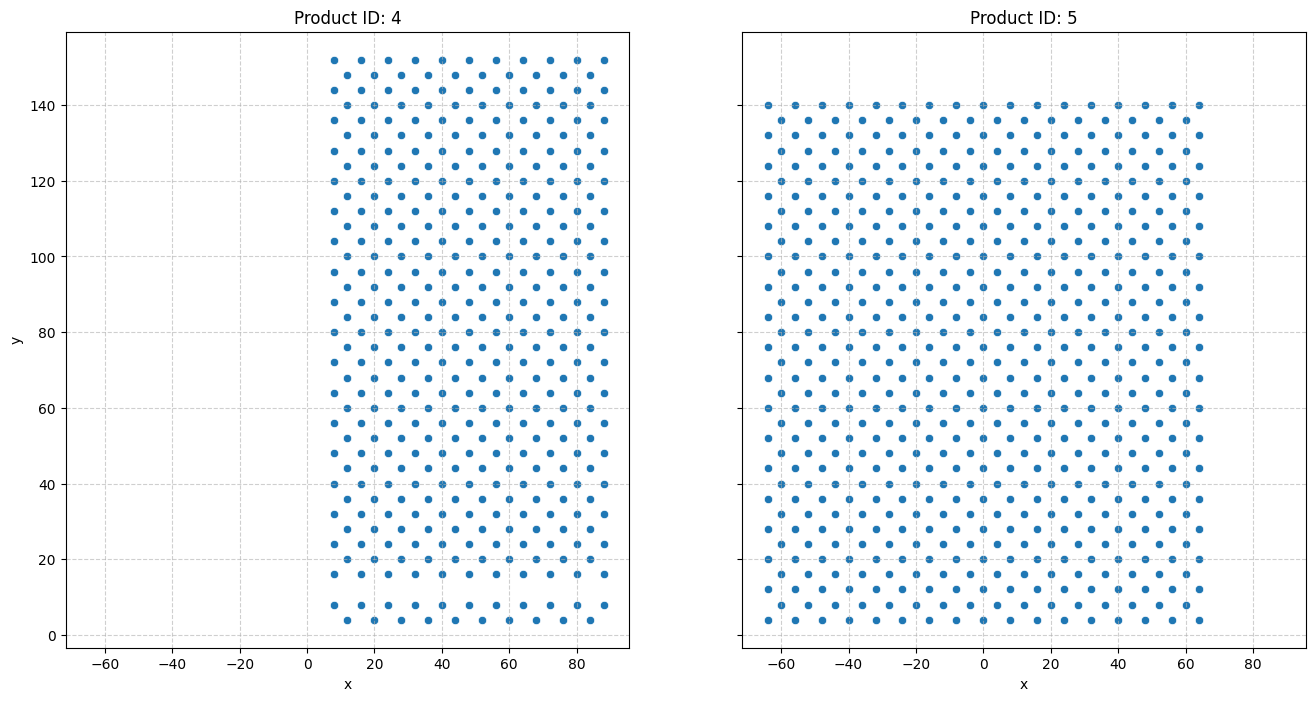

In [10]:
fig, axes = plt.subplots(1,2,figsize=(16,8), sharex=True, sharey=True)

for i,product_id in enumerate([4,5]):
    filtered = df_holes[df_holes["product_id"]==product_id]
    sns.scatterplot(filtered, x='x',y='y',ax=axes[i])
    axes[i].set_title(f"Product ID: {product_id}")
    axes[i].grid(True,alpha=.6, linestyle='--')

plt.show()

### Product 4 is the TB1, Product 5 is the TB2. We need to convert both of these hold-sets to real, physical holds. First step would be aligning them with their real, physical location on the board. Second step would be finding some way to manually add pull_dir+useability features.

I learned from the TB2 installation guide that these hole location measurements are in inches. Additionally, the TB2 DOESN'T HAVE A KICKBOARD! That's crazy, and a bit of a Mandela effect for me. I could swear it had one. But nope.

**The guide also comes with crystal clear hold orientations, and difficulty levels. This is exactly the data I'm looking for! Fuck yeah, Tension!** 

In [75]:
query = "SELECT * FROM placements"
df_placements = df_sql("tension",query,index_col=None).astype({'id': int, 'layout_id':int,'hole_id':int,'set_id':int,'default_placement_role_id':int})
tb2_layouts = [10,11]
df_placements = df_placements[df_placements['layout_id'].isin(tb2_layouts)].merge(
    df_holes,
    left_on='hole_id',
    right_on='id',
    how='inner'
)
df_p_spray=df_placements[df_placements['layout_id']==11]
spray_placement_to_hole = dict(zip(df_p_spray['id'],df_p_spray['hole_id']))
df_p_mirror=df_placements[df_placements['layout_id']==10]
mirror_placement_to_hole = dict(zip(df_p_mirror['id'],df_p_mirror['hole_id']))

df_placements.head()

,id,layout_id,hole_id,set_id,default_placement_role_id,product_id,name,x,y,mirrored_hole_id,mirror_group
0,304,10,672,12,8,5,"0,20",0,20,672,0
1,802,11,390,12,8,5,"-64,4",-64,4,950,0
2,305,10,675,12,5,5,"0,44",0,44,675,0
3,803,11,392,12,8,5,"-64,20",-64,20,952,0
4,306,10,676,12,6,5,"0,52",0,52,676,0


In [50]:
df_placements['x_ft'] = (df_placements['x']+72)/12
df_placements['y_ft'] = (df_placements['y'])/12
df_placements['is_foot'] = (df_placements['default_placement_role_id']%4==0).astype(int)
tb2_mirror = df_placements.loc[df_placements['layout_id']==10,['hole_id','x_ft','y_ft','is_foot']]
tb2_spray = df_placements.loc[df_placements['layout_id']==11,['hole_id','x_ft','y_ft','is_foot']]
tb2_spray.head()

,hole_id,x_ft,y_ft,is_foot
1,390,0.666667,0.333333,1
3,392,0.666667,1.666667,1
5,394,0.666667,3.000000,0
7,396,0.666667,4.333333,0
9,399,0.666667,6.333333,0


In [52]:
spray_holds = convert_dataframe_to_holds(tb2_spray)
upload_holds('wall-443c15cd12e0',spray_holds)

Uploading 498 holds to wall wall-443c15cd12e0...
Endpoint: http://localhost:8000/api/v1/walls/wall-443c15cd12e0/holds
✓ Successfully uploaded 498 holds!


{'id': 'wall-443c15cd12e0'}

In [70]:
query="""
        SELECT 
            c.uuid,
            c.name,
            c.layout_id,
            cs.angle,
            c.frames,
            cs.difficulty_average,
            cs.quality_average,
            cs.ascensionist_count,
            cs.fa_username,
            c.created_at
        FROM climbs c
        JOIN climb_stats cs ON c.uuid = cs.climb_uuid
        WHERE c.layout_id > 9
            AND cs.angle IS NOT NULL
            AND cs.ascensionist_count > 0
            AND cs.difficulty_average IS NOT NULL
            AND cs.quality_average IS NOT NULL
        ORDER BY cs.ascensionist_count DESC;
    """
df_climbs = df_sql("tension",query)
df_climbs.head()

,name,layout_id,angle,frames,difficulty_average,quality_average,ascensionist_count,fa_username,created_at
uuid,,,,,,,,,
18E0834CBBB64952AE12BB7DD7F56E28,Masquerade,10,40,p561r6p685r8p699r6p704r5p711r7p712r8p722r6p724...,16.0048,2.98476,10173,tensionclimbing,2022-08-19 23:25:31.319795
9BB53A94CE2E4B15819D9469466F6914,Drain from the Brain,10,40,p304r8p310r8p380r5p465r6p480r6p552r6p561r6p758r7,19.9889,2.99044,8680,bennykuttler1285,2022-11-22 21:52:07.547299
D6B81C3306C74A308E795CFCBADB78DB,Compliments To The Climber,10,40,p311r6p316r6p353r6p356r6p357r7p366r8p430r6p450...,17.9932,2.97241,8590,tensionclimbing,2022-08-23 19:17:03.576297
BA608169C0114B8ABB0AD7E7BA0D27C1,Putty,10,40,p348r8p436r8p454r8p462r6p466r8p480r6p484r8p485...,14.9999,2.98220,8481,tensionclimbing,2022-08-24 18:37:02.476646
823A103296DA449C90C4B865B5031629,Propagation,10,40,p343r5p348r8p466r8p484r8p485r8p547r8p681r5p690...,17.9954,2.98773,8070,tensionclimbing,2022-08-21 02:03:23.846586


In [78]:
parse_frames_to_holdset(df_climbs[df_climbs["layout_id"]==11].iloc[0,3])

{'start': [570],
 'finish': [512],
 'hand': [523, 576, 578, 587, 625, 619],
 'foot': [530, 498, 557, 565, 732]}

In [86]:
upload_climbs_batch(df_climbs[df_climbs["layout_id"]==10], wall_id='wall-0a877f13d8e5',hole_dict=mirror_placement_to_hole)
upload_climbs_batch(df_climbs[df_climbs["layout_id"]==11], wall_id='wall-443c15cd12e0',hole_dict=spray_placement_to_hole)

Progress: 500/38909 | Success: 500 | Errors: 0
Progress: 1000/38909 | Success: 1000 | Errors: 0
Progress: 1500/38909 | Success: 1500 | Errors: 0
Progress: 2000/38909 | Success: 2000 | Errors: 0
Progress: 2500/38909 | Success: 2500 | Errors: 0
Progress: 3000/38909 | Success: 3000 | Errors: 0
Progress: 3500/38909 | Success: 3500 | Errors: 0
Progress: 4000/38909 | Success: 4000 | Errors: 0
Progress: 4500/38909 | Success: 4500 | Errors: 0
Progress: 5000/38909 | Success: 5000 | Errors: 0
Progress: 5500/38909 | Success: 5500 | Errors: 0
Progress: 6000/38909 | Success: 6000 | Errors: 0
Progress: 6500/38909 | Success: 6500 | Errors: 0
Progress: 7000/38909 | Success: 7000 | Errors: 0
Progress: 7500/38909 | Success: 7500 | Errors: 0
Progress: 8000/38909 | Success: 8000 | Errors: 0
Progress: 8500/38909 | Success: 8500 | Errors: 0
Progress: 9000/38909 | Success: 9000 | Errors: 0
Progress: 9500/38909 | Success: 9500 | Errors: 0
Progress: 10000/38909 | Success: 10000 | Errors: 0
Progress: 10500/3890

[{'original_uuid': 'Pizza Box',
  'new_id': 'climb-e3465d263557',
  'status': 'success'},
 {'original_uuid': 'Aw, shoot',
  'new_id': 'climb-3b3bb814a962',
  'status': 'success'},
 {'original_uuid': 'Write This Way',
  'new_id': 'climb-f26669f8e525',
  'status': 'success'},
 {'original_uuid': 'Shoulder Rust',
  'new_id': 'climb-bb3770106571',
  'status': 'success'},
 {'original_uuid': 'Nacho Mango',
  'new_id': 'climb-dd162ef879f7',
  'status': 'success'},
 {'original_uuid': 'Frictionless',
  'new_id': 'climb-6b817f9fe923',
  'status': 'success'},
 {'original_uuid': 'Put It Up',
  'new_id': 'climb-fe99f9039824',
  'status': 'success'},
 {'original_uuid': 'Authorized',
  'new_id': 'climb-8cb385d6d41c',
  'status': 'success'},
 {'original_uuid': 'Pour Cece',
  'new_id': 'climb-c01967550c7c',
  'status': 'success'},
 {'original_uuid': 'Center Left',
  'new_id': 'climb-4eee1ffee2c5',
  'status': 'success'},
 {'original_uuid': 'It’s A Mid-West Alcohol',
  'new_id': 'climb-09deb97f7572',
  '